# MineB4USign: Mining Legal Documents/Terms and Conditions for Intent


## Content

- [Motivation](#Motivation)
- [End to End Picture: The Pipeline](#End-to-End-Picture:-The-Pipeline)
- [Architecture Diagram](#Architecture-Diagram)
- [Data collection and processing](#Data-collection-and-processing)
- [Lets Have a Look](#Lets-Have-a-Look)
- [Preprocessing](#Preprocessing)
- [Combined Dataframe of 115 Files](#Combined-Dataframe-of-115-Files)
- [Machine Learning Algorithms](#Machine-Learning-Algorithms)
    - [SVM](#SVM)
    - [Reasons For Selecting SVM](#Reasons-For-Selecting-SVM)
    - [Metrics](#Metrics)
    - [Training SVM Classifiers](#Training-SVM-Classifiers)
- [Matrics Values For Trained Models](#Matrics-Values-For-Trained-Models)
- [User Friendly Annotated Terms and Conditions Page](#User-Friendly-Annotated-Terms-and-Conditions-Page)
- [Pittfalls and how to avoid them](#Pittfalls-and-how-to-avoid-them)
- [Further Resources](#Further-Resources)
- [References and Citations](#References-and-Citations)

## Motivation

How many times have we accepted the terms and conditions while signing up for a service like the google photos etc ? Not a very prudent thing to do right ? We dont blame you. Since all of us use a vast number of such "free" services, its not practical to read through all of the conditions. It is very time consuming (As CMU students thats the last thing we have in plenty !!!). But that does not mean we should not be well informed of what we are signing up for right ?

If only there were a way to get a better understanding of such legal documents without having to read the entire thing. For example, get a general overview of what the document means and try to get answers to questions like 

1. Does the document talk about Data Retention and Data Security, if so to what extent the data retention happens?
2. Who is collecting the data: Is it a first party collection or even the third party apps/websites are allowed to collect data?
3. What is the scope of the audience? International or specfic? 
4. What about the User access/choice and control over the services and data? 

Once we get the answers to these questions extracted out of the document, wouldn't it be great if we can categorize them and  the pick and choose to read only those parts of the document that address a subset of such categories that are important to me. For example, I may be only interested to read those parts of the text that speak about sharing my data with a third party. 

All these pave a way for interesting usecases like 
1. Apply interesting Machine Learning algorithms to get an insight of such documents.
2. Visually appealing presentation of the document highlighting such important categories.
3. A frameworkf for legal Question and Answering system
4. Intent based text summarization.

So, without further ado, let us present our solution pipeline for problem. 
But wait, just one last thing to add to our motivation! <br> <br>
__Below is how plain and boring raw terms and conditions page looks like. Later, we will show how we can use our solution pipeline to draw insights of such page and transform it to have a user friendly look and feel.__

In [77]:
 %%HTML
<iframe width="100%" height="600" src="Privacy Policy – Privacy & Terms – Google.html"></iframe>


In [78]:
 %%HTML
<iframe width="100%" height="600" src="google_preprocess.html"></iframe>

## End to End Picture: The Pipeline

Any actual ML implementation has a lot more to it than just implementing a ML algorithm. A typical pipeline includes:-
- __Data collection and processing__: 
Whenever we start designing and developing a solution for an ML problem, the major chunk of the work goes collecting and cleaning the data to suit the ML model and algorithm. Though it may seem trivial but in reality is the most important part of the pipeline. Research has shown that many of the ML problems can be solved with relatively simpler techniques as long as there is enough good data.
       
- __Statistical modeling: Getting a feel of the data__:
It is important to understand the data before we try to using ML to find some patterns in it. To quote what Prof Zico says, it is highly likely that unless we are manually able to see a pattern, the ML model will. 
        
- __Advanced ML techniques__: 
Here comes the actual implementation of the ML algorithm which is the core of the pipeline.

- __Data visualization__:
All things done so far may not be sufficient to depict the big picture to the end customer who are indifferent to Machine Learning and only care about whether their time is worth what you want to show them. Visualization can be a great tool to convince someone. As they say, a picture is worth a thousand words.


In this project, we have extensively covered the entire pipeline to give an end to end perspective of how Machine Learning can be used to solve a problem.

## Architecture Diagram

![Image_architecture.png](Image_architecture.png)


- First we feed the sign-up policies which are in the form of raw HTML documents to a pre-processing phase. 
- We then generate tf-idf features out of it.
- We feed this to a hierarchical SVM model and train using cross 

## Data collection and processing

Here, we are colleting and processing the OPP-115 Corpus. A substantially large amount of work had to be done to bring the data to a format which can be fed to a Machine Learning model.

- __OPP-115__:
For a very long time, there was no labeled data available for analysis of terms and conditions. Enters the OPP-155 data set. This can be used to study the general patterns followed by companies that ask people to accepts their terms and conditions.
In its pure form the data is noisy and as such is useless to an ML model. But once it is cleaned and framed, its pure gold. 
- __Usage__:
Using this data, we are training a model that helps us answer questions we raised in our "motivations" subheading. 
For example-
    - Segmenting the entire document and trying to categorize the segments as to what they tell us about each of the categories ( 'Data Retention', 'Data Security', 'Do Not Track', 'First Party Collection/Use', 'International and Specific Audiences', 'Other', 'Policy Change', 'Third Party Sharing/Collection','User Access, Edit and Deletion', 'User Choice/Control')

The categories are defined as follows:

1. First Party Collection/Use: How and why a service provider collects user information
2. Third Party Sharing/Collection: How user information may be shared with or collected by third parties
3. User Choice/Control: Choices and control options available to users
4. User Access, Edit, & Deletion: If and how users can access, edit, or delete their information
5. Data Retention: How long user information is stored
6. Data Security: How user information is protected
7. Policy Change: If and how users will be informed about changes to the privacy policy
8. Do Not Track: If and how Do Not Track signals1 for online tracking and advertising are honored
9. International & Specific Audiences: Practices that pertain only to a specific group of users (e.g., children, residents of the European Union, or Californians)
10. Other: Additional privacy-related information not covered by the above categories2
    
Source: https://www.usableprivacy.org/static/files/CMU-ISR-17-118.pdf

In [79]:
import pandas as pd
import numpy as np
import json
import os
import re
from bs4 import BeautifulSoup

In [80]:
def extract_sentences(data, segment, isprint = False):
    """
    parse raw data in the form of raw HTML.
    
    Args:
        data (string): String of properly formatted JSON.
        segment: the unit measurement of the data
        isprint: arg to simplify logging

    Returns: collated_sentences: sentences from paragraphs
            dictionary_subcategories: A dict of subcategories.
        
    """
    def allindices(string, sub, offset=0):
        listindex = []
        i = string.find(sub, offset)
        while i >= 0:
            listindex.append(i)
            i = string.find(sub, i + 1)
        return listindex
#     print("Segment:", segment)
    soup = BeautifulSoup()
    left_fullstop = -10000
    left_break_tag = -10000
    right_fullstop = 10000
    right_break_tag = 10000

    dictionary_subcategories = {}
    collated_sentences = []
    json_data = json.loads(data)
    for attribute, value in json_data.items():
#         print("attribute:", attribute)
        endIndexInSegment = value["endIndexInSegment"]-1
        if isprint:
            print("endIndexInSegment:", endIndexInSegment)
        startIndexInSegment = value["startIndexInSegment"]
        if isprint:
            print("startIndexInSegment:", startIndexInSegment)

        json_value = value["value"]
        if json_value == "Unspecified":
            continue
        else:
            if startIndexInSegment == 0 and endIndexInSegment == len(segment):
                collated_sentences.append(segment[startIndexInSegment:endIndexInSegment-1].strip())
                continue
            if startIndexInSegment == 0:
                left_fullstop = 0
                left_break_tag = 0
            if endIndexInSegment == len(segment):
                right_fullstop = 0
                right_break_tag = 0
            
            
#             print("value: ", value)
            full_stops = allindices(segment, ".")
            break_tags = allindices(segment, "<br>")
            if isprint:
                print("full_stops: ", full_stops)
            if isprint:
                print("break_tags: ", break_tags)
            left_fullstops = [x for x in full_stops if x <= startIndexInSegment]
            right_fullstops = [x for x in full_stops if x >= endIndexInSegment]
            left_break_tags = [x for x in break_tags if x <= startIndexInSegment]
            right_break_tags = [x for x in break_tags if x >= endIndexInSegment]
            
            if len(left_fullstops) > 1: 
                if left_fullstop is not 0:
                    left_fullstop = max(left_fullstops)+1
            else:
                if len(left_fullstops) == 1:
                    if left_fullstop is not 0:
                        left_fullstop = left_fullstops[0]+1

            if len(right_fullstops) > 1: 
                if right_fullstops is not 0:
                    right_fullstop = min(right_fullstops)+1
            else:
                if len(right_fullstops) == 1:
                    if right_fullstop is not 0:
                        right_fullstop = right_fullstops[0]+1
                        
            if len(left_break_tags) > 1: 
                if left_break_tag is not 0:
                    left_break_tag = max(left_break_tags)+4
            else:
                if len(left_break_tags) == 1:
                    if left_break_tag is not 0:
                        left_break_tag = left_break_tags[0]+4

            if len(right_break_tags) > 1: 
                if right_break_tag is not 0:
                    right_break_tag = min(right_break_tags)+4
            else:
                if len(right_break_tags) == 1:
                    if right_break_tag is not 0:
                        right_break_tag = right_break_tags[0]+4

            if isprint:
                print("right_fullstop: ", right_fullstop)
            if isprint:
                print("right_break_tag: ", right_break_tag)
            left = max(left_fullstop, left_break_tag)
            right = min(right_fullstop, right_break_tag)
            if isprint:
                print("Collated segment:", segment[left:right].strip())
            sentence = segment[left:right].strip()
            cleantext = BeautifulSoup(sentence, "lxml").text
            if cleantext not in collated_sentences:
                collated_sentences.append(cleantext)
            else:
                continue
            dictionary_subcategories[attribute] = cleantext
#     print("dictionary_subcategories: ", dictionary_subcategories)
    return collated_sentences, dictionary_subcategories

In [81]:
def create_df(path_sanitized_policies = "OPP-115/sanitized_policies/" , path_annotations = "OPP-115/consolidation/threshold-1.0-overlap-similarity/"):
    """
    Creates a data frame for specified file
    
    Args:
       path_sanitized_policies: file path of the policy
       path_annotations: file path of the annotations
    Returns: dictionary: key as filename and value as the processed DF.
        
    """
    def find(S, T):
        return [match.start() for match in re.finditer(re.escape(S), T)]

    dictionary = {}
    regex_html = "(.*).html"
    regex_csv = "(.*).csv"
    for filename_sanitized_policies in os.listdir(path_sanitized_policies):
        if filename_sanitized_policies == ".DS_Store":
            continue
        m = re.match(regex_html, filename_sanitized_policies)
        groups = m.groups()
        filename_sanitized_policies_no_extension = groups[0]
        path_sanitized_policies_file = path_sanitized_policies + "/" + filename_sanitized_policies 
        f = open(path_sanitized_policies_file, "r")
        content = f.read()
        
        temp_positions = find("|||", content)
        a = 0
        all_positions = [a] + temp_positions
        all_positions_end = temp_positions + [len(content)]
        
        segments = content.split("|||")
        path_annotations_file = path_annotations + filename_sanitized_policies_no_extension + ".csv"
        annotations = pd.read_csv(path_annotations_file, keep_default_na = False, names = ["annotation ID", "batch ID", "annotator ID", "policy ID", "segment ID", "category name", "attribute-value", "policy URL", "date"]) 
        annotations = pd.concat([annotations, pd.get_dummies(annotations['category name'])], axis=1)
        sLength = len(annotations['annotation ID'])
        annotations['segment'] = pd.Series(np.random.randn(sLength), index=annotations.index)
        annotations['segment'] = annotations['segment'].astype('str')
        
        annotations['collated_sentences'] = pd.Series(np.random.randn(sLength), index=annotations.index)
        annotations['collated_sentences'] = annotations['segment'].astype('str')
        annotations['sub_categories_dictionary'] = pd.Series(np.random.randn(sLength), index=annotations.index)
        annotations['sub_categories_dictionary'] = annotations['sub_categories_dictionary'].astype('object')
        annotations['start'] = [all_positions[i] for i in annotations["segment ID"]]
        annotations['end'] = [all_positions_end[i] for i in annotations["segment ID"]]
        count = 1
        for i, row in annotations.iterrows():
            segment_id = row['segment ID']
            cleansegment = BeautifulSoup(segments[segment_id], "html").text
            annotations.at[i, 'segment'] = cleansegment
            count +=1
            istrue = False
            collated_sentences, dictionary_subcategories = extract_sentences(annotations.at[i, 'attribute-value'], segments[segment_id], istrue)
            annotations.at[i, 'collated_sentences'] = collated_sentences
            annotations.at[i, 'sub_categories_dictionary'] = dictionary_subcategories
            
        dictionary[filename_sanitized_policies_no_extension] = annotations
    return dictionary
        

## Feeling the Data

Here we manually analyse and understand the data. This is essential gauge what sort of Machine Learning algorithm we can implement on top of this data.



In [83]:
# This command calls the above functions to create a dataframe for the files present in the directory.
annotations = create_df()

## Lets Have a Look

Lets Have a Look at google's privacy policy page converted into a dataframe.

In [84]:
annotations['google.com'].head()

,annotation ID,batch ID,annotator ID,policy ID,segment ID,category name,attribute-value,policy URL,date,Data Retention,Data Security,First Party Collection/Use,International and Specific Audiences,Other,Policy Change,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control,segment,collated_sentences,sub_categories_dictionary,start,end
0,15956,test_category_labeling_highlight_fordham_bbbbb,116,3864,0,Other,"{""Other Type"": {""selectedText"": ""Welcome to th...",6/30/15,https://www.google.com/intl/en/policies/privacy/,0,0,0,0,1,0,0,0,0,Welcome to the Google Privacy Policy When ...,[ Welcome to the Google Privacy Policy When...,{'Other Type': ' Welcome to the Google Privacy...,0,442
1,18039,test_category_labeling_highlight_fordham_ccccc,117,3864,0,Other,"{""Other Type"": {""selectedText"": ""When you use ...",6/30/15,https://www.google.com/intl/en/policies/privacy/,0,0,0,0,1,0,0,0,0,Welcome to the Google Privacy Policy When ...,"[When you use Google services, you trust us wi...","{'Other Type': 'When you use Google services, ...",0,442
2,16704,test_category_labeling_highlight_fordham_ddddd,118,3864,0,Other,"{""Other Type"": {""selectedText"": ""When you use ...",6/30/15,https://www.google.com/intl/en/policies/privacy/,0,0,0,0,1,0,0,0,0,Welcome to the Google Privacy Policy When ...,"[When you use Google services, you trust us wi...","{'Other Type': 'When you use Google services, ...",0,442
3,16705,test_category_labeling_highlight_fordham_ddddd,118,3864,0,User Choice/Control,"{""Choice Type"": {""selectedText"": ""you can find...",6/30/15,https://www.google.com/intl/en/policies/privacy/,0,0,0,0,0,0,0,0,1,Welcome to the Google Privacy Policy When ...,"[And remember, you can find controls to manage...","{'Choice Type': 'And remember, you can find co...",0,442
4,15957,test_category_labeling_highlight_fordham_bbbbb,116,3864,1,Policy Change,"{""Change Type"": {""selectedText"": ""Privacy Poli...",6/30/15,https://www.google.com/intl/en/policies/privacy/,0,0,0,0,0,1,0,0,0,"Privacy Policy Last modified: June 30, 2015 ...","[Privacy Policy Last modified: June 30, 2015...",{'Notification Type': 'Privacy Policy Last m...,442,534


## Preprocessing

Once we analyse the data manually, we can see if any further changes need to be made in order to feed it to an ML algorithm that we are contemplating about. 

In [85]:
# This code cleans the sentence and does preprocessing
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
"""
Preprocess a list of sentences
    
Args:
    sentences (list): A list of sentences to be preprocessed
Returns:
    Preprocessed sentence
"""

stop_words = set(stopwords.words('english'))

def preprocess(list_sentence):
    sentence = ''.join(list_sentence)
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    filtered_words = filter(lambda token: token not in stop_words, tokens)
    processed_sentence = " ".join(filtered_words)
    return processed_sentence

sentence = """We also use the information we collect to maintain and improve the quality,
security and integrity of our services. For example we may use this information
for research purposes and to improve the relevancy of Bing search results. 
This information is also necessary in order to detect and protect against 
security threats such as botnet attacks, click fraud, worms, and other threats. 
For Microsoft Services that are powered by Bing, we may also use this information 
to personalize your experience. Please see the Microsoft Services Powered by Bing 
section for more information."""
print("Original Text \n")
print(sentence)
print(" ")
print("Processed Text \n")
print(preprocess(sentence))

Original Text 

We also use the information we collect to maintain and improve the quality,
security and integrity of our services. For example we may use this information
for research purposes and to improve the relevancy of Bing search results. 
This information is also necessary in order to detect and protect against 
security threats such as botnet attacks, click fraud, worms, and other threats. 
For Microsoft Services that are powered by Bing, we may also use this information 
to personalize your experience. Please see the Microsoft Services Powered by Bing 
section for more information.
 
Processed Text 

also use information collect maintain improve quality security integrity service example may use information research purpose improve relevancy bing search result information also necessary order detect protect security threat botnet attack click fraud worm threat microsoft service powered bing may also use information personalize experience please see microsoft service powered 

In [86]:
# The following libraries are used for SVM
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
import math
from collections import Counter

In [87]:
#Preparing categories and sub-categories into a list and dictionary respectively
categories = ['Data Retention', 'Data Security', 'Do Not Track', 'First Party Collection/Use', 'International and Specific Audiences', 'Other', 'Policy Change', 'Third Party Sharing/Collection','User Access, Edit and Deletion', 'User Choice/Control']
sub_categories = {}
sub_categories['First Party Collection/Use']=['Does/Does Not','Collection Mode','Action First-Party','Identifiability','Personal Information Type','Purpose','User Type','Choice Type','Choice Scope']
sub_categories['Third Party Sharing/Collection']=['Third Party Entity','Does/Does Not','Action Third Party','Identifiability','Personal Information Type','Purpose','User Type','Choice Type','Choice Scope']
sub_categories['User Choice/Control']=['Choice Type','Choice Scope','Personal Information Type','Purpose','User Type']
sub_categories['User Access, Edit and Deletion']=['Access Type''Access Scope','User Type']
sub_categories['Data Retention']=['Retention Period','Retention Purpose','Personal Information Type']
sub_categories['Data Security']=['Security Measure']
sub_categories['Policy Change']=['Change Type','Notification Type','User Choice']
sub_categories['Do Not Track']=['Do Not Track policy']
sub_categories['International and Specific Audiences']=['Audience Type']
sub_categories['Other']=['Other Type']
for cat in categories:
    print("Category:",cat,"\n","sub_categories :",sub_categories[cat],"\n")                     

Category: Data Retention 
 sub_categories : ['Retention Period', 'Retention Purpose', 'Personal Information Type'] 

Category: Data Security 
 sub_categories : ['Security Measure'] 

Category: Do Not Track 
 sub_categories : ['Do Not Track policy'] 

Category: First Party Collection/Use 
 sub_categories : ['Does/Does Not', 'Collection Mode', 'Action First-Party', 'Identifiability', 'Personal Information Type', 'Purpose', 'User Type', 'Choice Type', 'Choice Scope'] 

Category: International and Specific Audiences 
 sub_categories : ['Audience Type'] 

Category: Other 
 sub_categories : ['Other Type'] 

Category: Policy Change 
 sub_categories : ['Change Type', 'Notification Type', 'User Choice'] 

Category: Third Party Sharing/Collection 
 sub_categories : ['Third Party Entity', 'Does/Does Not', 'Action Third Party', 'Identifiability', 'Personal Information Type', 'Purpose', 'User Type', 'Choice Type', 'Choice Scope'] 

Category: User Access, Edit and Deletion 
 sub_categories : ['Acces

In [88]:
# This code combines all dataframes and cleans the respective text values, finally returns a dataframe
"""
Combine all dataframes for 115 Privacy Policies into a dataframe
and process segments, paragraphs.
    
Args:
    annotations (dict) : A dictionary of annotations where text from a privacy
    policy is and collatted in a dataframe.
Returns:
    all_df (dataframe) : Combined dataframe
"""
def collate_all_categories(annotations):
    all_df = pd.DataFrame()
    for key, val in annotations.items():
        cat_df = pd.DataFrame()
        cat_df = annotations[key].drop(['sub_categories_dictionary'], axis=1)
        all_df = all_df.append(cat_df)
    all_df['collated_sentences'] = [preprocess(list_s) for list_s in all_df['collated_sentences']]
    all_df = all_df.fillna(value=0.0)
    return all_df
all_df_categories = collate_all_categories(annotations)

In [89]:
# This code is used for plotting tf-idf features
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    color = ['#a04a24', '#1b8268']
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color=color[i])
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

## Skewed Data

As one can see from the plot below, the data is very skewed. For example the "Do not track" has very little examples as compared to the other categories. While this did not seem like a big deal to us, it given highly improper results. 

To solve this either of the following two can be done.
1. Sample the training examples to make them proportional. This is not the best way to go about it from our experimentation.
2. The second thing is to give class weights to the model.

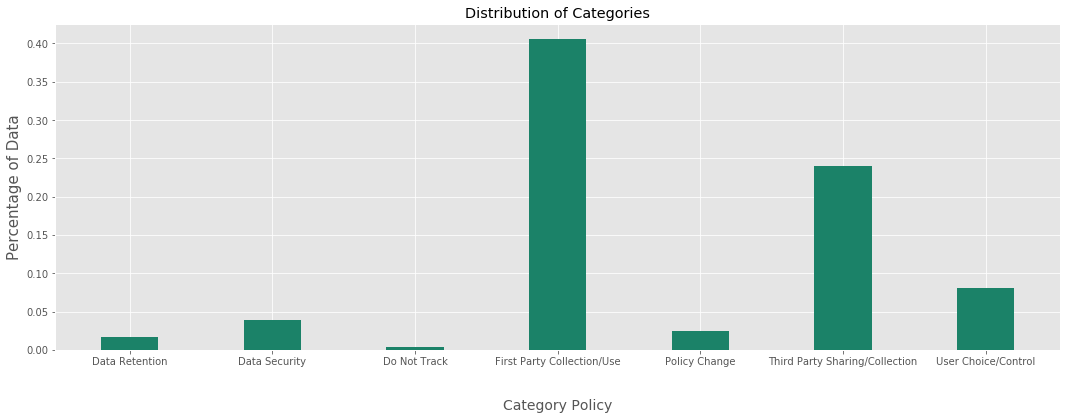

In [90]:
def plot_categories(annotations):
    """
    Combine all dataframes for 115 Privacy Policies into a dataframe
    and process segments, paragraphs.
    
    Args:
        annotations (dict) : A dictionary of annotations where text from a privacy
        policy is and collatted in a dataframe.
    Returns:
        plots distribution of positive labels in percentage.
    """
    total_count = len(all_df_categories)
    cat_count = {}
    cat_weight = {}
    cat_dict_count = {}
    categories_list = ['Data Retention', 'Data Security', 'Do Not Track', 'First Party Collection/Use', 'Policy Change', 'Third Party Sharing/Collection','User Choice/Control']
    for cat in categories_list:
        cat_dict = Counter(all_df_categories[cat])
        cat_count[cat] = cat_dict[1.0]/total_count
        cat_weight[cat] = (math.ceil(total_count/cat_dict[0.0]), math.ceil(total_count/cat_dict[1.0]))
    plt.figure(figsize=(18,6))
    plt.bar(cat_count.keys(), cat_count.values(), color='#1b8268', width=0.4)
    plt.xlabel('Category Policy', labelpad=32, fontsize=14)
    plt.ylabel('Percentage of Data', fontsize=15)
    plt.title('Distribution of Categories')
    plt.show()
plot_categories(annotations)

## Combined Dataframe of 115 Files

In [91]:
all_df_categories
pd.options.display.max_columns = None
display(all_df_categories.head())


,Data Retention,Data Security,Do Not Track,First Party Collection/Use,International and Specific Audiences,Other,Policy Change,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control,annotation ID,annotator ID,attribute-value,batch ID,category name,collated_sentences,date,end,policy ID,policy URL,segment,segment ID,start
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15956,116,"{""Other Type"": {""selectedText"": ""Welcome to th...",test_category_labeling_highlight_fordham_bbbbb,Other,welcome google privacy policy use google servi...,https://www.google.com/intl/en/policies/privacy/,442,3864,6/30/15,Welcome to the Google Privacy Policy When ...,0,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18039,117,"{""Other Type"": {""selectedText"": ""When you use ...",test_category_labeling_highlight_fordham_ccccc,Other,use google service trust u information privacy...,https://www.google.com/intl/en/policies/privacy/,442,3864,6/30/15,Welcome to the Google Privacy Policy When ...,0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16704,118,"{""Other Type"": {""selectedText"": ""When you use ...",test_category_labeling_highlight_fordham_ddddd,Other,use google service trust u information privacy...,https://www.google.com/intl/en/policies/privacy/,442,3864,6/30/15,Welcome to the Google Privacy Policy When ...,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16705,118,"{""Choice Type"": {""selectedText"": ""you can find...",test_category_labeling_highlight_fordham_ddddd,User Choice/Control,remember find control manage information prote...,https://www.google.com/intl/en/policies/privacy/,442,3864,6/30/15,Welcome to the Google Privacy Policy When ...,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15957,116,"{""Change Type"": {""selectedText"": ""Privacy Poli...",test_category_labeling_highlight_fordham_bbbbb,Policy Change,privacy policy last modified june 30 2015 view...,https://www.google.com/intl/en/policies/privacy/,534,3864,6/30/15,"Privacy Policy Last modified: June 30, 2015 ...",1,442


### Finally, all the preprocessing (almost) is done. Now we can finally move forward.

## Machine Learning Algorithms

After analysing the data that we are working with, we realized that SVM would be one of the better options.

### SVM
In machine learning, support vector machines (SVMs, also support vector networks[1]) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier (although methods such as Platt scaling exist to use SVM in a probabilistic classification setting). An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall. (Source: Wikipedia)

### Reasons For Selecting SVM 
- SVMs has the ability to learn independent of the dimensionality of the feature space.
- Since the maximum margin is drawn based only on the support vectors and not the number of features, it can generalize even in the presence of very many features
- SVM is very robust, eliminating the need for expensive parameter tuning which plagues other methods.
- Text categorize problems are linearly separable which fits into the behaviour of SVM. 
- SVM is good for cases where there is sparse data. Since the document vectors are sparse, SVM will perform well on it.


## Metrics

We will be using the following metrices to measure our model's performance.

- Accuracy: (tp + tn) / (tp + fp + fn + tn)
- specificity: tn / (tn + fp)  
- sensitivity: tp / (tp + fn) 
- precision: tp / (tp + fp)
- f1score: 2*tp / (2*tp + fp + fn)

tf-> true positive<br>
fp->false positive<br>
tn->true negative<br>
fn->false negative<br>

In [92]:
"""
Analyse Confusion Matrix
    
Args: 
    confusion_matrix (numpy matrix) : Confusion Matrix
Returns:
    measures (dict) : A dictionary of scores on various metrics
"""
def analyse_confusion_matrix(conf_mat):
    tp, fp, fn, tn = conf_mat.flatten()
    measures = {}
    measures['accuracy'] = (tp + tn) / (tp + fp + fn + tn)
    measures['specificity'] = tn / (tn + fp)        
    measures['sensitivity'] = tp / (tp + fn)    
    measures['precision'] = tp / (tp + fp)
    measures['f1score'] = 2*tp / (2*tp + fp + fn)
    return measures

In [93]:
def evaluate(y_pred, y_test):
    """ Evaluates classifier predictions
        Inputs:
            y_pred (array_like): output from classifier
            y_test (array_like): true class label
        Output:
            (double): accuracy rate as defined above
    """
    len_range=len(y_test)
    count = float(np.sum(y_pred==y_test))
    accuracy = (count)/len_range
    return accuracy
    pass

## Training SVM Classifiers

Now we train SVM classifiers for categories of different privacy policies. We found that for cases where accuracy was high, cross validation did not improve the performance significantly while in other cases it did.

In [94]:
def build_category_models(categories_list, cross_validate = True):
    """
    Build Category SVM Models one per category
    
    Args: 
        categories list to be processed and boolean to perform cross validation.
    Returns:
        measures (dict) :dict of tf-idf vectorizers
                        :dict of trained SVM models for each category
                        :dict of fp and fn indexes for each category
                        :dict of corpus, tf-idf matrix, labels for tf-idf analysis
                        :dict of accuracy, confusion matrix for each category
    """

    vectorizer_dict = {}
    model_dict = {}
    false_pos = {}
    false_neg = {}
    cat_corpus = {}
    cat_TFIDF = {}
    cat_labels = {}
    cat_accuracy = {}
    cat_confusion_matrix_dict = {}
    cat_score_dict = {}
    
    
    for cat in categories_list:
        exp_df = pd.DataFrame()
        exp_df[cat]=all_df_categories[cat]
        exp_df['segment ID']=all_df_categories['segment ID']
        exp_df['collated_sentences']=all_df_categories['collated_sentences']
        exp_df = exp_df.drop_duplicates(subset=['segment ID',cat,'collated_sentences'], keep='first')

        corpus = exp_df['collated_sentences'].values
        labels = exp_df[cat].reset_index(drop=True)
        totalsvm = 0           
        ConfusionMat = np.zeros((2,2));
        scores_kfold = []
        false_pos[cat] = set()
        false_neg[cat] = set()

        
        if (cross_validate):
        
            kf = StratifiedKFold(n_splits=2, shuffle=True)

            modelSVC = SVC(kernel='linear', class_weight='balanced')
            for train_index, val_index in kf.split(corpus,labels):
                X_train = [corpus[i] for i in train_index]
                X_val = [corpus[i] for i in val_index]
                y_train, y_val = labels[train_index], labels[val_index]

                vectorizer = TfidfVectorizer(ngram_range = (2,3), sublinear_tf=True, use_idf=True, stop_words='english')
                train_corpus_tf_idf = vectorizer.fit_transform(X_train)
                val_corpus_tf_idf = vectorizer.transform(X_val)
                


                modelSVC.fit(train_corpus_tf_idf,y_train)
                resultSVC_labels = np.squeeze(modelSVC.predict(val_corpus_tf_idf))
                scores_kfold.append(evaluate(resultSVC_labels, y_val))
            ConfusionMat = confusion_matrix(y_val, resultSVC_labels)
            cat_confusion_matrix_dict[cat] = ConfusionMat

            #Collect indices of false positive and negatives
            fp_idx = np.where((resultSVC_labels==1) & (y_val==0))[0]
            fn_idx = np.where((resultSVC_labels==0) & (y_val==1))[0]
            
            
            #Update Category values in dictionary
            false_pos[cat].update(val_index[fp_idx])
            false_neg[cat].update(val_index[fn_idx])
#             cat_accuracy[cat] = scores
            vectorizer_dict[cat]=vectorizer
            model_dict[cat]= modelSVC
            cat_corpus[cat] = corpus[train_index]
            cat_TFIDF[cat] = train_corpus_tf_idf
            cat_labels[cat] = y_train
            cat_score_dict[cat] = analyse_confusion_matrix(ConfusionMat)
        else:
            vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, ngram_range = (2,3), sublinear_tf=True, use_idf=True, stop_words='english')
            #building TF-IDF Matrix
            X = corpus
            #splitting the dataset
            P = np.random.permutation(X.shape[0])
            test_index = math.floor(0.8*len(P))
            train_indexes=P[0:test_index]
            test_indexes=P[test_index:]
            X_train = vectorizer.fit_transform(X[train_indexes])
            X_test = vectorizer.transform(X[test_indexes])
            y_train = labels[train_indexes]
            y_test = labels[test_indexes]
            #train classifier
            clf = SVC(kernel='linear', class_weight='balanced')
            clf.fit(X_train, y_train)
            #predict and evaluate predictions
            predictions = clf.predict(X_test)
            #false positive and negatives
            fp_idx = np.where((predictions==1) & (y_test==0))[0]
            fn_idx = np.where((predictions==0) & (y_test==1))[0]
            #Update Category values in dictionary
            false_pos[cat].update(test_indexes[fp_idx])
            false_neg[cat].update(test_indexes[fn_idx])
            
            vectorizer_dict[cat]=vectorizer
            model_dict[cat]=clf
            cat_corpus[cat] = corpus[train_indexes]
            cat_TFIDF[cat] = X_train
            cat_labels[cat] = y_train
        
            ConfusionMat = confusion_matrix(y_test, predictions)
            cat_confusion_matrix_dict[cat] = ConfusionMat
            cat_score_dict[cat] = analyse_confusion_matrix(ConfusionMat)
            
            
    return(model_dict, vectorizer_dict, false_pos, false_neg, cat_corpus, cat_TFIDF, cat_labels, cat_confusion_matrix_dict, cat_score_dict)
model_dict, vectorizer_dict, false_pos, false_neg, cat_corpus, cat_TFIDF, cat_labels, cat_confusion_matrix_dict, cat_score_dict = build_category_models(categories, False)

## Matrics Values For Trained Models

Lets have a look at how our models performed as per the metrics mentioned in the cells above. As we can see that for categories which did not have an imbalanced distribution of positive and negative labels, we observe improved performance over all the metrics. The result is quite similar to the baselines established by research (https://www.usableprivacy.org/static/files/CMU-ISR-17-118.pdf).

In [95]:
df = pd.DataFrame(data=cat_score_dict)
df.head()

,Data Retention,Data Security,Do Not Track,First Party Collection/Use,International and Specific Audiences,Other,Policy Change,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control
accuracy,0.966970,0.954719,0.997592,0.837209,0.959943,0.793666,0.977000,0.853943,0.958891,0.902798
f1score,0.983051,0.976052,0.998790,0.873919,0.978873,0.864069,0.988125,0.901665,0.978649,0.945580
precision,0.976574,0.968000,0.999516,0.848845,0.967678,0.826291,0.985686,0.869697,0.973814,0.922320
sensitivity,0.989614,0.984240,0.998066,0.900520,0.990331,0.905466,0.990575,0.936073,0.983533,0.970044
specificity,0.283582,0.511450,0.875000,0.731009,0.507576,0.500000,0.591549,0.647541,0.397727,0.450549


Now that we have trained models for category prediction lets go a step further and build models to detect presence of sub-categories.

In [96]:
def collate_all_sub_categories(annotations):
    """
    collate_all_sub_categories

    Args: 
        annotations: a dict of data frames for all corpus documents.
    Returns:
        a dataframe for all corpus documents comnbined and sub-categories labeled as one hot vectors
    """
    all_df_category = {}
    
    # Create dataframe by combining values from all files
    all_df = pd.DataFrame()
    for key, val in annotations.items():
        sub_cat_df = pd.DataFrame()
        sub_cat_df = annotations[key].drop(['collated_sentences'], axis=1)
        all_df = all_df.append(sub_cat_df)
    all_df_sub_cats = all_df.fillna(value=0.0)
    all_df_sub_cats=all_df_sub_cats.reset_index()
    for index, row in all_df_sub_cats.iterrows():
        cat = row['category name']
        sub_cat_keys = list(row['sub_categories_dictionary'].keys())
        for sub_cat in sub_categories[cat]:
            if (sub_cat in sub_cat_keys):
                all_df_sub_cats.loc[index, sub_cat]=preprocess(row['sub_categories_dictionary'][sub_cat])
                all_df_sub_cats.loc[index, sub_cat+'_label']=1
            else:
                all_df_sub_cats.loc[index, sub_cat]=preprocess(row['segment'])
                all_df_sub_cats.loc[index, sub_cat+'_label']=0
    
    return all_df_sub_cats
all_df_sub_cats = collate_all_sub_categories(annotations)
print("Sub Category DataFrame Built.. ")
print("Dataframe is of length ", len(all_df_sub_cats))

Sub Category DataFrame Built.. 
Dataframe is of length  20417


In [97]:
def build_sub_categories_models(all_df_sub_categories):
    """
    Build SVM Models for Sub Categories at Sentence Level granularity 
    
    Args: 
        all_df_sub_categories: a dataframe of all corpus documents
    Returns:
        dict of tf-idf vectorizer, trained SVM models for each sub-category
    """

    model_dict = {}
    vectorizer_dict = {}
    for cat in categories:
        cat_df = all_df_sub_categories
        for sub_cat in sub_categories[cat]:
            new_df = pd.DataFrame()
            new_df[sub_cat]=cat_df[sub_cat]
            new_df['segment ID']=cat_df['segment ID']
            new_df['labels'] = cat_df[sub_cat+'_label']
            new_df = new_df.drop_duplicates(subset=['segment ID',sub_cat], keep='first')
            new_df = new_df.dropna(axis=0, how='any')
            corpus = new_df[sub_cat].values
            labels = new_df['labels'].reset_index(drop=True)
            zero_samples = Counter(labels)[0.0]
            one_samples = Counter(labels)[1.0]
            if(not zero_samples or not one_samples):
                break
            totalsvm = 0           
            ConfMatrix = np.zeros((2,2));  
            
            vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, ngram_range = (2,3), sublinear_tf=True, use_idf=True, stop_words='english')
            X = corpus
            P = np.random.permutation(X.shape[0])
            test_index = math.floor(0.8*len(P))
            train_indexes=P[0:test_index]
            test_indexes=P[test_index:]
            X_train = vectorizer.fit_transform(corpus[train_indexes])
            X_test = vectorizer.transform(corpus[test_indexes])
            y_train = labels[train_indexes]
            y_test = labels[test_indexes]
            clf = SVC(kernel='linear', class_weight='balanced')
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_test)
        
            model_dict[sub_cat]=clf
            vectorizer_dict[sub_cat]=vectorizer
    
    return(model_dict, vectorizer_dict)
sub_category_model, sub_category_vectorizer=build_sub_categories_models(all_df_sub_cats)

## Analysis of TF-IDF Features

When we train the model and plot the confusion matrix (Shown a few cells below) we can see that a few documents have been misclassified. On taking a closer look at the TFIDF features, it is apparant as to why that is happening. All categories have a few words which are occuring in both the positive and the negative labels. This confuses the SVM a bit and makes it classify segments incorrectly in some cases. For example words like __personal information__ is occuring very frequently in both postive and negative labels of category __User Access, Edit and Deletion__.

Further, we found that bigrams and trigrams lead to better tf-idf feature selection when compared to unigrams since they remove single words which dont really carry an intent which models its category.

We have shown a subset of the analysis plot below (feel free to make changes in the code below to see a more comprehensive category analysis).





Analysis of Categories : First Party Collection/Use


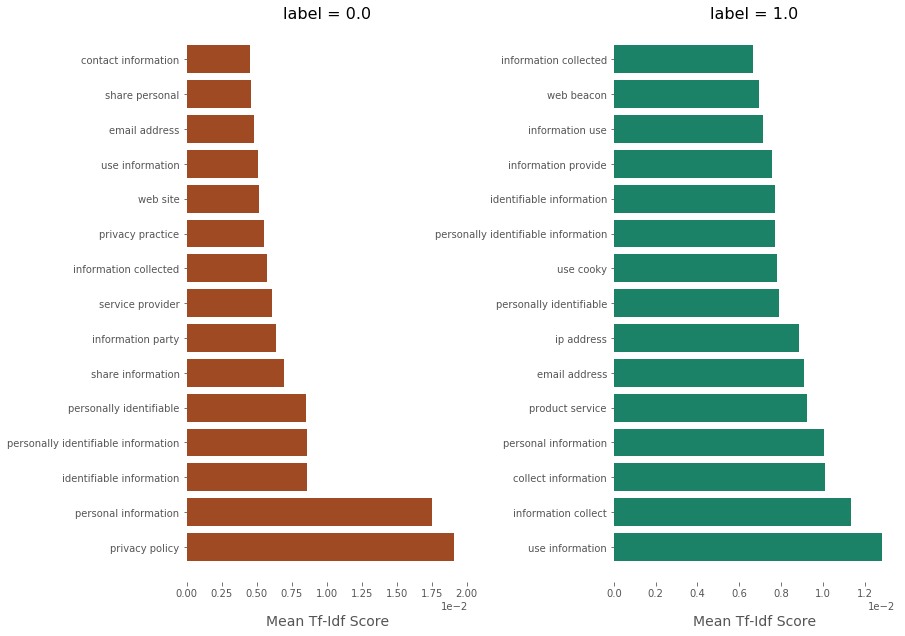

Analysis of Categories : Third Party Sharing/Collection


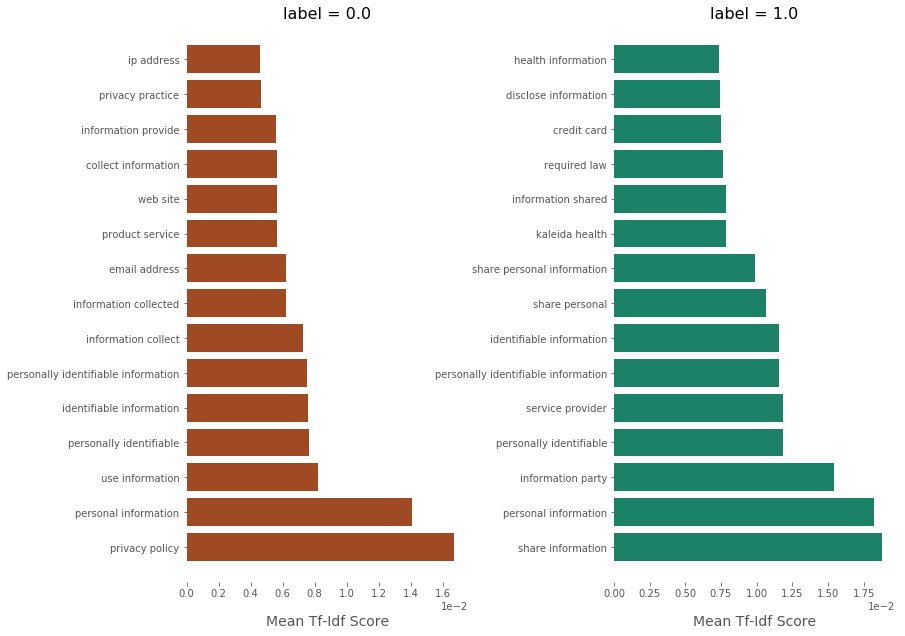

Analysis of Categories : User Access, Edit and Deletion


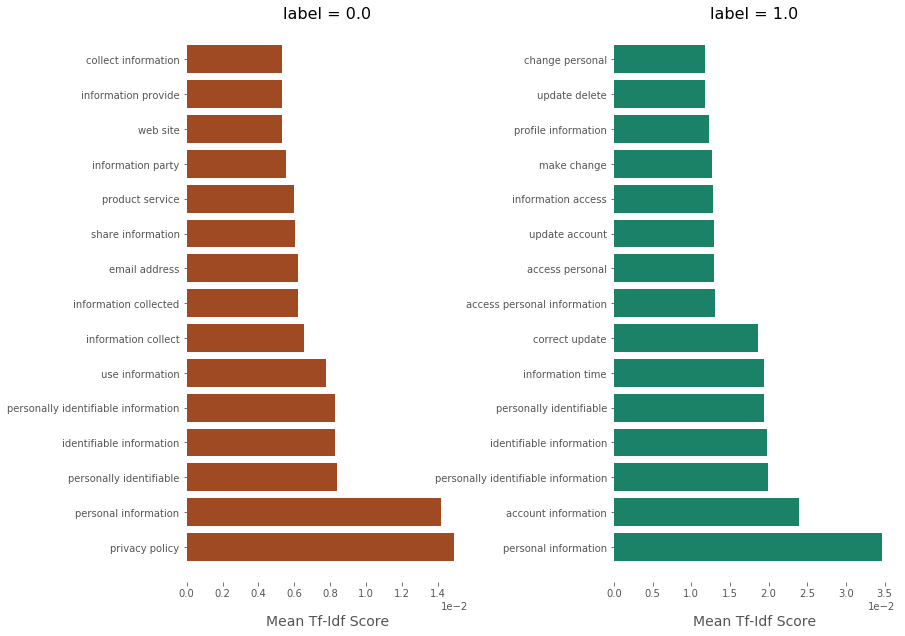

In [98]:

"""
Combination of functions that does analysis of TFIDF Features for specific categories.  
"""
features = {}
for cat in categories:
    features[cat] = vectorizer_dict[cat].get_feature_names()

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

show = ['First Party Collection/Use', 'Third Party Sharing/Collection','User Access, Edit and Deletion']


for cat in categories:
    if cat in show:
        dfs = top_feats_by_class(cat_TFIDF[cat], cat_labels[cat], features[cat], min_tfidf=0.1, top_n=15)
        print("Analysis of Categories :", cat)
        plot_tfidf_classfeats_h(dfs)



Now that we have everything that we need, lets build an end to end module that takes as argument trained SVM modeles and tf-idf vectorizers and returns predicted category and sub-category labels for previously unseen documents.

In [100]:
def end_to_end(categories, model_dict, vectorizer_dict, sub_category_model, sub_category_vectorizer):
    """
    end-end module for testing of documents
    
    Args:
            Trained models and tf-idf vectorizers
    Returns:
            Predicted category and sub category labels in a dataframe.
    
    """
    path_sanitized_policies = "OPP-115/sanitized_policy_test/"
    path_annotations = "OPP-115/consolidation_test/"
    test_df = create_df(path_sanitized_policies, path_annotations)
    test_df_dict = {}
    for k, v in test_df.items():
        temp = pd.DataFrame()
        temp["segment ID"] = v["segment ID"]
        temp["segment"] = v["segment"]
        temp["category name"] = v["category name"]
        temp["start"] = v["start"]
        temp["end"] = v["end"]
       
        temp = temp.drop_duplicates(subset=['segment ID'], keep='first')
        temp["segment"] = [preprocess(list_s) for list_s in temp["segment"]]
        temp["analysis"] = ''
        corpus_temp = temp["segment"].values
        
        for category in categories:
            vectorizer = vectorizer_dict[category]
            X_vect = vectorizer.transform(corpus_temp)
            temp[category] = model_dict[category].predict(X_vect)
            indexes = temp.index[temp[category] == 1.0].tolist()
            if (indexes):
                if category == "International and Specific Audiences":
                    for idx in indexes:
                        temp.loc[idx, "analysis"]+=" "+ "Audience Type"
                    continue
                if category == "Other":
                    for idx in indexes:
                        temp.loc[idx, "analysis"]+=" "+ "Other Policies"
                    continue
                to_predict = [temp.loc[idx, 'segment'] for idx in indexes]
                for sub_cat in sub_categories[category]:
                    try:
                        sub_cat_model=sub_category_model[sub_cat]
                    except:
                        break
                    if (sub_cat_model):
                        predictions = sub_cat_model.predict(sub_category_vectorizer[sub_cat].transform(to_predict))
                        for idx in indexes:
                            i=0
                            if (predictions[i]==1.0):
                                temp.loc[idx, "analysis"]+=" "+sub_cat
                            i+=1
                    else:
                        for idx in indexes:
                            temp.loc[idx, "analysis"]+=" "+sub_cat
                        
        test_df_dict[k] = temp
    return test_df_dict
test_doc_dict = end_to_end(categories, model_dict, vectorizer_dict, sub_category_model, sub_category_vectorizer)

## Confusion Matrix

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another). [__Source- Wikipedia__]


We have used confusion matrix to better understand under what labels is it classifying incorrectly. When we use this information along with the insight we have derived from the plots of the highest tf-idf values, we see exactly why our model misclassifies some segments: Few words occur in both the positive and the negative labels. This confuses the SVM a bit and makes it classify segments incorrectly in some cases.


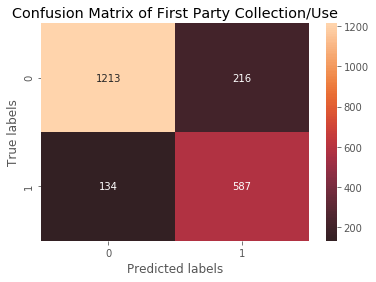

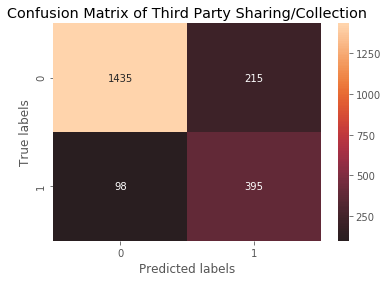

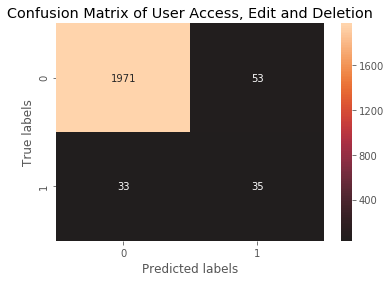

In [101]:
import seaborn as sns

def plot_confusion_matrix_seaborn(cat_confusion_matrix_dict):
    """
    Plot confusion matrix for visual analysis
    
    Args:
            Confusion matrix dict for categories.
    """
    show = ['First Party Collection/Use', 'Third Party Sharing/Collection','User Access, Edit and Deletion']
    for key, cm in cat_confusion_matrix_dict.items():
        if key in show:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            sns.heatmap(cm, annot=True, ax = ax, center=0, fmt="d"); #annot=True to annotate cells
            # labels, title and ticks
            ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
            ax.set_title('Confusion Matrix of ' + key); 
            ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
plot_confusion_matrix_seaborn(cat_confusion_matrix_dict)

## User Friendly Annotated Terms and Conditions Page
Finally, as we promised, we will show how we can change the terms/conditions pages to look more appealing and understandable. 
We color code each of the segments and also provide a quick clean tooltip that says what is a particular segment in the page taking about when hovered on the same.


In [102]:
#The color coding is based on the following scheme
'''Segment --> code
Data Retention, Data Security --> brown
Others --> Grey
First Party Collection/Use --> orange
Policy Change --> yellow
Third Party Sharing/Collection --> red 
User Access, Edit and Deletion, User Choice/Control --> green
'''
span_id = {'Data Retention':'brown', 'Data Security':'brown','Other':'grey', 'First Party Collection/Use':'orange', 'Policy Change':'yellow', 'Third Party Sharing/Collection':'red','User Access, Edit and Deletion':'green', 'User Choice/Control':'green'}


def embed_style_script():
    style = """<style> .tooltip {position: relative; display: inline-block;} .tooltip .tooltiptext {visibility: hidden;width: 120px;background-color: white;color: black;text-align: center;border-radius: 6px;padding: 5px 0;border-left: 5px solid #e8ecef;border-right: 5px solid #e8ecef; border-top: 5px solid #e8ecef;border-bottom: 5px solid #e8ecef ;z-index: 1;position: absolute;opacity: 0.8;}.tooltip:hover .tooltiptext {visibility: visible;position: fixed;overflow: hidden;} #grey{background-color:#c3c6cc;} #red{background-color:#edb8bf;} #blue{background-color:#5fd5dd;} #brown{background-color:#db9360;} #yellow{background-color:#e3f28e;}  #green{background-color:#b8edb8;} #orange{background-color:#e3f28e;}</style><head><script src="https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js"> </script><script> $(document).ready(function(){$(".tooltip").mouseover(function(){$(".tooltiptext").css({top: event.clientY-100 , left: event.clientX-100 }).show();}); $(".tooltip").mouseleave(function(){setTimeout(function() {$('.tooltiptext').fadeOut('fast');}, 500);});});</script></head>"""
    return style

def embed_span_div(s,id,df):
    category_name = (df.loc[df['segment ID'] == id]['category name'].item())
    sub_categories = (df.loc[df['segment ID'] == id]['analysis'].item())
    span_element = '<span id="'+ span_id[category_name] + '">'
    div_element = '<span class="tooltiptext" id="moveThis"> <h4>Categories</h4>'+category_name+'<h4>Sub-categories</h4>'+sub_categories+'</span> </div>'
    return '<div class="tooltip" >'+span_element + s + '</span>' + div_element

def visualize(in_file,out_file,df):
    with open(in_file) as infile:
        content = infile.readlines()

    segments = content[0].split("|||")
    output = embed_style_script() + "\n"
    i=0
    for s in segments:
        output += embed_span_div(s,i,df) + "\n"
        i +=1
    
    with open(out_file, 'w') as out:
        out.write(output)





In [103]:
visualize("google_preprocess.html","output.html",ti['591_google.com'])

### Below is the same google terms and documents file (that we showed in the beginning of the notebook) that is color coded and annotated based on segement categories. We can just hover on any segment and examine what category it belongs to.

In [104]:
 %%HTML
<iframe width="100%" height="600" src="output.html"></iframe>

## Pittfalls and how to avoid them

In this we will address some of the common pittfalls and how we solved them.

- Skewed Data:
In a lot of real world cases, the labels of the data that we have may be very skewed. For our case, in a lot of categories, we had a very uneven distribution of the labels 0 and 1. In such a case, the SVM model will not be accurate. The way we make this work is by introducing a class weight proportional to each of the labels.
- Identification of phrases:
For our corpus, well trained assessors determined and classified sub-categories based on the presence of certain keywords. These intents have been identified by humans based on their understanding and scales. We have selected sentences that contain these keywords to create and mark presence of sub-categories as labels. 
 

## Future Works:


- A lot can be built on this framework that we have built on in this project. We have shown text higlighting plugin as an example in the cells above.

- This can be extended to include a Question Answer system wherein a user could query the policy document with questions like "Do you share my data with third parties ?". And answer to this question would require identifying paragraphs within the privacy policy document and further looking for the presence of negative and positive connotations. This could be done with models like RNN that preserve the context of a window around the text to train a model.
- The real motivation behind choosing this project was to present the user with a simplified veracular of the privacy policy document that a layman could understand. A possible opimization of this could be a text summarization system. 
- It would be highly benificial to build models that can identify accurately phrases that justify the prediction of labels thst justify the presence of a category or a sub-category.

## Further Resources

https://www.usableprivacy.org/static/files/Which-Apps-have-Privacy-Policies-Poster.pdf<br>
https://www.usableprivacy.org/static/files/CMU-ISR-17-114R.pdf<br>
http://www.cs.cmu.edu/~breaux/publications/hosseini-aaai16.pdf<br>
http://www.andrew.cmu.edu/user/pgl/financialnotices-UnderReview.pdf<br>


## References and Citations

- https://gist.github.com/ameyavilankar/10347201
- https://buhrmann.github.io/tfidf-analysis.html
- http://scikit-learn.org/stable/
